# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [16]:
from google.colab import files
uploaded = files.upload()

Saving problem_unittests.py to problem_unittests.py


In [0]:
import helper

In [17]:
!ls


helper.py  problem_unittests.py  __pycache__  sample_data


In [9]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

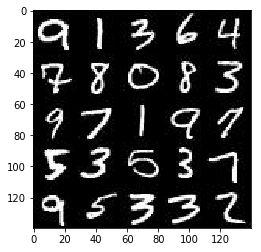

In [11]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

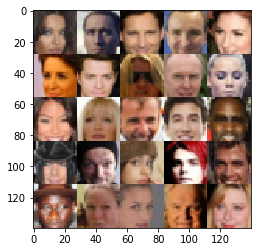

In [12]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.14.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [21]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(tf.float32, (None,image_height,image_width,image_channels),"input_images")
    z_data = tf.placeholder(tf.float32, (None,z_dim),"z_data")
    learning_rate = tf.placeholder(dtype = tf.float32,name = "learning_rate")
    return input_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [123]:
alpha = .2
dropout = .8
initializerr = tf.random_normal_initializer(stddev=0.02)
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        h1 = tf.layers.conv2d(images, 64, 5, strides=2,kernel_initializer=initializerr, padding='same')
        h1 = tf.maximum(alpha * h1, h1)
        h1 = tf.nn.dropout(h1, 0.8)
        
        h2 = tf.layers.conv2d(h1, 128, 5, strides=2,kernel_initializer=initializerr, padding='same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)
        h2 = tf.nn.dropout(h2, 0.8)
        
        h3 = tf.layers.conv2d(h2, 256, 5, strides=2,kernel_initializer=initializerr, padding='same')
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)
        h3 = tf.nn.dropout(h3, 0.8)
        
        flat = tf.reshape(h3, (-1, 4*4*256))
        dropout_layer = tf.layers.dropout(inputs=flat, rate=dropout)
        logits = tf.layers.dense(dropout_layer, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [124]:

def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        h1 = tf.layers.dense(z, 3*3*512)
        h1 = tf.reshape(h1, (-1, 3, 3, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
        h1 = tf.nn.dropout(h1, 0.8)

        
        h2 = tf.layers.conv2d_transpose(h1, 256, kernel_size=5, strides=2,kernel_initializer=initializerr, padding='same')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
        h2 = tf.nn.dropout(h2, 0.8)
        
        h3 = tf.layers.conv2d_transpose(h2, 128, kernel_size=4, strides=2,kernel_initializer=initializerr, padding='valid')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
        h3 = tf.nn.dropout(h3, 0.8)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, kernel_size=5,strides=2,kernel_initializer=initializerr, padding='same')
        out = tf.tanh(logits)
        
    return out      


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [125]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [126]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [0]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [0]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, print_every=20, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0

    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images*=2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                steps+=1
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/4... Discriminator Loss: 2.9212... Generator Loss: 0.0829
Epoch 1/4... Discriminator Loss: 1.0642... Generator Loss: 0.6192
Epoch 1/4... Discriminator Loss: 1.3566... Generator Loss: 3.2583
Epoch 1/4... Discriminator Loss: 0.6676... Generator Loss: 2.2309
Epoch 1/4... Discriminator Loss: 0.9642... Generator Loss: 0.9654


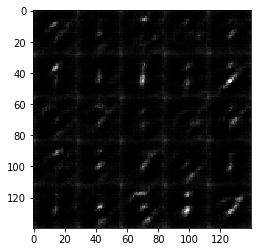

Epoch 1/4... Discriminator Loss: 1.5289... Generator Loss: 0.3197
Epoch 1/4... Discriminator Loss: 1.4875... Generator Loss: 0.3555
Epoch 1/4... Discriminator Loss: 0.9863... Generator Loss: 0.6880
Epoch 1/4... Discriminator Loss: 1.0431... Generator Loss: 0.6347
Epoch 1/4... Discriminator Loss: 1.0455... Generator Loss: 0.5994


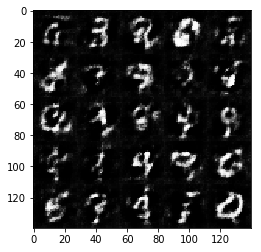

Epoch 1/4... Discriminator Loss: 1.0927... Generator Loss: 0.5729
Epoch 1/4... Discriminator Loss: 1.0589... Generator Loss: 0.6475
Epoch 1/4... Discriminator Loss: 0.9706... Generator Loss: 0.6720
Epoch 1/4... Discriminator Loss: 1.3793... Generator Loss: 0.3893
Epoch 1/4... Discriminator Loss: 0.8883... Generator Loss: 0.8318


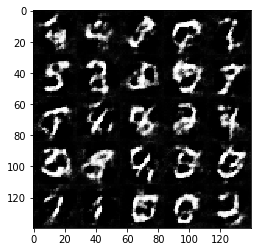

Epoch 1/4... Discriminator Loss: 1.0099... Generator Loss: 0.6383
Epoch 1/4... Discriminator Loss: 1.1938... Generator Loss: 0.5078
Epoch 1/4... Discriminator Loss: 0.9782... Generator Loss: 0.7017
Epoch 1/4... Discriminator Loss: 1.0208... Generator Loss: 0.6188
Epoch 1/4... Discriminator Loss: 1.0086... Generator Loss: 0.6395


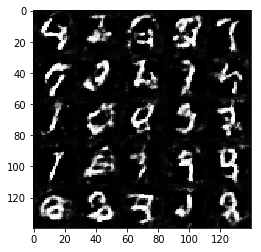

Epoch 1/4... Discriminator Loss: 1.0608... Generator Loss: 0.5981
Epoch 1/4... Discriminator Loss: 1.0241... Generator Loss: 0.6495
Epoch 1/4... Discriminator Loss: 1.1307... Generator Loss: 0.5609
Epoch 2/4... Discriminator Loss: 0.8784... Generator Loss: 0.8203
Epoch 2/4... Discriminator Loss: 1.1051... Generator Loss: 0.6481


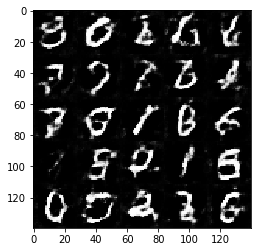

Epoch 2/4... Discriminator Loss: 1.0169... Generator Loss: 0.6262
Epoch 2/4... Discriminator Loss: 1.1847... Generator Loss: 0.5021
Epoch 2/4... Discriminator Loss: 1.2371... Generator Loss: 0.5224
Epoch 2/4... Discriminator Loss: 0.7493... Generator Loss: 1.3607
Epoch 2/4... Discriminator Loss: 0.8400... Generator Loss: 1.1377


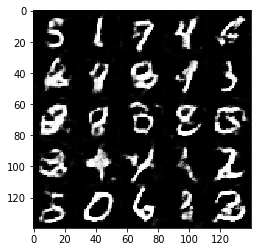

Epoch 2/4... Discriminator Loss: 0.9476... Generator Loss: 0.6954
Epoch 2/4... Discriminator Loss: 0.6953... Generator Loss: 1.1625
Epoch 2/4... Discriminator Loss: 0.9044... Generator Loss: 0.8285
Epoch 2/4... Discriminator Loss: 1.3169... Generator Loss: 0.4327
Epoch 2/4... Discriminator Loss: 0.7177... Generator Loss: 1.3587


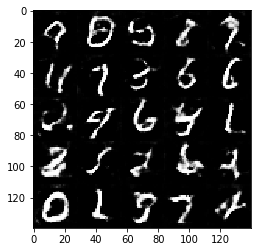

Epoch 2/4... Discriminator Loss: 0.7629... Generator Loss: 1.2560
Epoch 2/4... Discriminator Loss: 0.7009... Generator Loss: 1.2389
Epoch 2/4... Discriminator Loss: 2.8196... Generator Loss: 3.2573
Epoch 2/4... Discriminator Loss: 0.6687... Generator Loss: 1.2225
Epoch 2/4... Discriminator Loss: 0.8308... Generator Loss: 1.6746


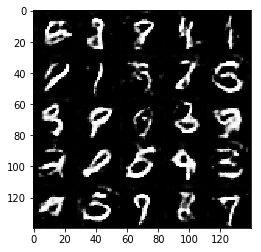

Epoch 2/4... Discriminator Loss: 0.7880... Generator Loss: 0.8380
Epoch 2/4... Discriminator Loss: 1.4773... Generator Loss: 0.3579
Epoch 2/4... Discriminator Loss: 1.5237... Generator Loss: 0.3549
Epoch 2/4... Discriminator Loss: 1.0792... Generator Loss: 2.2753
Epoch 2/4... Discriminator Loss: 0.6987... Generator Loss: 1.8374


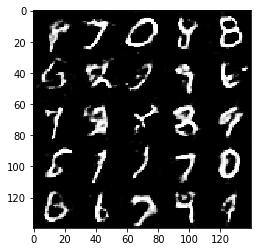

Epoch 2/4... Discriminator Loss: 0.9880... Generator Loss: 0.6395
Epoch 3/4... Discriminator Loss: 0.7500... Generator Loss: 0.9356
Epoch 3/4... Discriminator Loss: 2.3414... Generator Loss: 3.3978
Epoch 3/4... Discriminator Loss: 0.7320... Generator Loss: 0.8609
Epoch 3/4... Discriminator Loss: 0.9946... Generator Loss: 1.1727


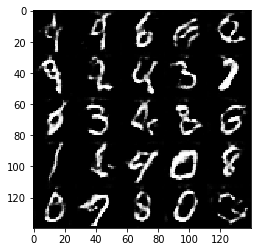

Epoch 3/4... Discriminator Loss: 0.6230... Generator Loss: 1.0780
Epoch 3/4... Discriminator Loss: 1.1529... Generator Loss: 0.4871
Epoch 3/4... Discriminator Loss: 0.9241... Generator Loss: 0.7197
Epoch 3/4... Discriminator Loss: 0.6837... Generator Loss: 0.9790
Epoch 3/4... Discriminator Loss: 3.8518... Generator Loss: 4.9508


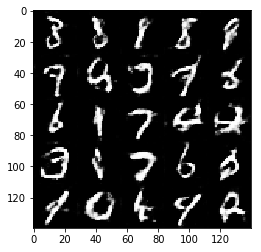

Epoch 3/4... Discriminator Loss: 0.8621... Generator Loss: 1.9360
Epoch 3/4... Discriminator Loss: 0.8083... Generator Loss: 1.8653
Epoch 3/4... Discriminator Loss: 0.5800... Generator Loss: 1.1542
Epoch 3/4... Discriminator Loss: 1.9479... Generator Loss: 3.4084
Epoch 3/4... Discriminator Loss: 0.5407... Generator Loss: 1.5057


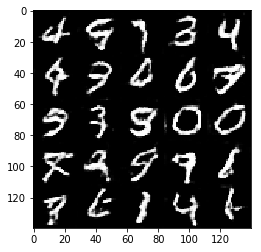

Epoch 3/4... Discriminator Loss: 0.9843... Generator Loss: 0.7877
Epoch 3/4... Discriminator Loss: 0.3721... Generator Loss: 2.1086
Epoch 3/4... Discriminator Loss: 0.9139... Generator Loss: 0.7934
Epoch 3/4... Discriminator Loss: 0.5529... Generator Loss: 1.3758
Epoch 3/4... Discriminator Loss: 1.2563... Generator Loss: 2.6541


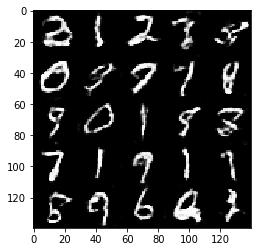

Epoch 3/4... Discriminator Loss: 0.9449... Generator Loss: 1.1857
Epoch 3/4... Discriminator Loss: 0.9418... Generator Loss: 0.8556
Epoch 3/4... Discriminator Loss: 0.4600... Generator Loss: 1.8233
Epoch 3/4... Discriminator Loss: 0.4877... Generator Loss: 1.3603
Epoch 3/4... Discriminator Loss: 0.7586... Generator Loss: 2.1611


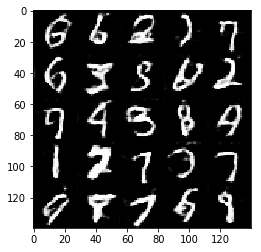

Epoch 4/4... Discriminator Loss: 1.1311... Generator Loss: 0.5266
Epoch 4/4... Discriminator Loss: 0.3723... Generator Loss: 1.6481
Epoch 4/4... Discriminator Loss: 0.3884... Generator Loss: 1.9177
Epoch 4/4... Discriminator Loss: 0.8183... Generator Loss: 1.0328
Epoch 4/4... Discriminator Loss: 0.5940... Generator Loss: 1.0509


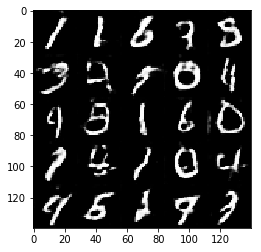

Epoch 4/4... Discriminator Loss: 0.5713... Generator Loss: 1.8139
Epoch 4/4... Discriminator Loss: 0.4564... Generator Loss: 1.9168
Epoch 4/4... Discriminator Loss: 0.8686... Generator Loss: 2.1219
Epoch 4/4... Discriminator Loss: 0.7976... Generator Loss: 0.9242
Epoch 4/4... Discriminator Loss: 0.9314... Generator Loss: 0.6344


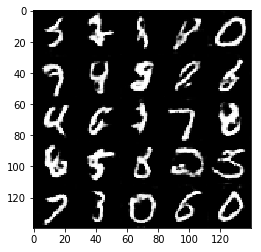

Epoch 4/4... Discriminator Loss: 1.1961... Generator Loss: 0.5685
Epoch 4/4... Discriminator Loss: 0.4660... Generator Loss: 1.4644
Epoch 4/4... Discriminator Loss: 0.6313... Generator Loss: 2.8062
Epoch 4/4... Discriminator Loss: 0.4568... Generator Loss: 1.5337
Epoch 4/4... Discriminator Loss: 0.7683... Generator Loss: 3.1189


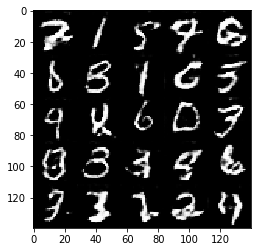

Epoch 4/4... Discriminator Loss: 1.5133... Generator Loss: 3.5179
Epoch 4/4... Discriminator Loss: 0.4286... Generator Loss: 2.0397
Epoch 4/4... Discriminator Loss: 0.2175... Generator Loss: 2.2693
Epoch 4/4... Discriminator Loss: 1.3490... Generator Loss: 0.4236
Epoch 4/4... Discriminator Loss: 0.7776... Generator Loss: 0.9998


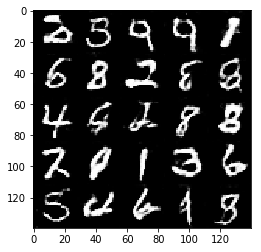

Epoch 4/4... Discriminator Loss: 0.4598... Generator Loss: 1.7459
Epoch 4/4... Discriminator Loss: 0.3734... Generator Loss: 1.4604
Epoch 4/4... Discriminator Loss: 0.3358... Generator Loss: 1.6974


In [121]:
batch_size = 128
z_dim = 100
learning_rate = .0005
beta1 = .2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 4

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/3... Discriminator Loss: 1.2882... Generator Loss: 12.9875
Epoch 1/3... Discriminator Loss: 0.3211... Generator Loss: 3.3858
Epoch 1/3... Discriminator Loss: 0.6724... Generator Loss: 2.9233
Epoch 1/3... Discriminator Loss: 0.5955... Generator Loss: 1.4630
Epoch 1/3... Discriminator Loss: 0.3665... Generator Loss: 1.6789


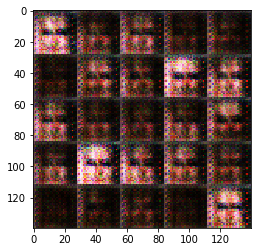

Epoch 1/3... Discriminator Loss: 0.7208... Generator Loss: 1.2802
Epoch 1/3... Discriminator Loss: 3.0683... Generator Loss: 3.9021
Epoch 1/3... Discriminator Loss: 0.6532... Generator Loss: 2.6313
Epoch 1/3... Discriminator Loss: 0.5429... Generator Loss: 2.1587
Epoch 1/3... Discriminator Loss: 1.1155... Generator Loss: 0.6890


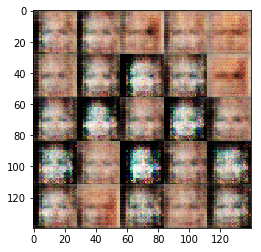

Epoch 1/3... Discriminator Loss: 1.7093... Generator Loss: 3.2182
Epoch 1/3... Discriminator Loss: 0.5318... Generator Loss: 2.3680
Epoch 1/3... Discriminator Loss: 0.9687... Generator Loss: 1.0631
Epoch 1/3... Discriminator Loss: 1.1153... Generator Loss: 0.7422
Epoch 1/3... Discriminator Loss: 1.1072... Generator Loss: 1.0581


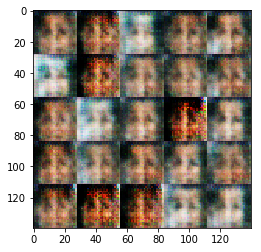

Epoch 1/3... Discriminator Loss: 0.8002... Generator Loss: 1.4319
Epoch 1/3... Discriminator Loss: 0.8996... Generator Loss: 1.1015
Epoch 1/3... Discriminator Loss: 0.5208... Generator Loss: 1.3662
Epoch 1/3... Discriminator Loss: 0.5670... Generator Loss: 1.2780
Epoch 1/3... Discriminator Loss: 0.7017... Generator Loss: 1.9916


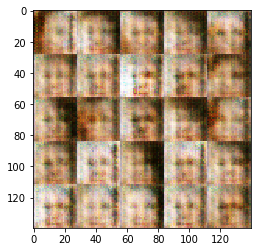

Epoch 1/3... Discriminator Loss: 1.5080... Generator Loss: 0.4674
Epoch 1/3... Discriminator Loss: 0.6851... Generator Loss: 1.6626
Epoch 1/3... Discriminator Loss: 0.9662... Generator Loss: 1.2171
Epoch 1/3... Discriminator Loss: 0.9381... Generator Loss: 1.2955
Epoch 1/3... Discriminator Loss: 1.1196... Generator Loss: 0.7758


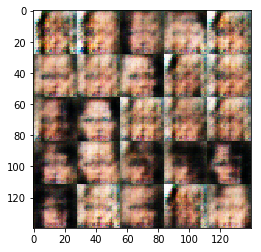

Epoch 1/3... Discriminator Loss: 1.3403... Generator Loss: 3.6118
Epoch 1/3... Discriminator Loss: 0.7004... Generator Loss: 2.1279
Epoch 1/3... Discriminator Loss: 1.1566... Generator Loss: 1.0640
Epoch 1/3... Discriminator Loss: 0.9793... Generator Loss: 1.2242
Epoch 1/3... Discriminator Loss: 0.6708... Generator Loss: 1.3096


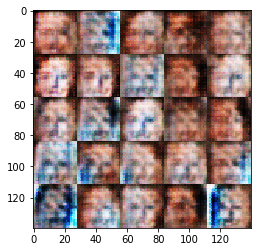

Epoch 1/3... Discriminator Loss: 0.9962... Generator Loss: 0.9871
Epoch 1/3... Discriminator Loss: 1.2086... Generator Loss: 0.8464
Epoch 1/3... Discriminator Loss: 0.6851... Generator Loss: 1.5362
Epoch 1/3... Discriminator Loss: 0.8398... Generator Loss: 2.1804
Epoch 1/3... Discriminator Loss: 0.6763... Generator Loss: 1.2777


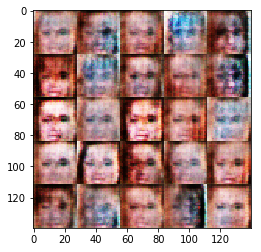

Epoch 1/3... Discriminator Loss: 0.6430... Generator Loss: 1.4452
Epoch 1/3... Discriminator Loss: 1.0378... Generator Loss: 0.9253
Epoch 1/3... Discriminator Loss: 0.4539... Generator Loss: 2.2674
Epoch 1/3... Discriminator Loss: 0.8029... Generator Loss: 2.0219
Epoch 1/3... Discriminator Loss: 0.6514... Generator Loss: 1.8709


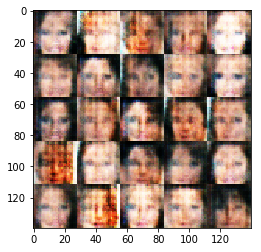

Epoch 1/3... Discriminator Loss: 0.6950... Generator Loss: 2.7435
Epoch 1/3... Discriminator Loss: 1.0356... Generator Loss: 2.2995
Epoch 1/3... Discriminator Loss: 0.7154... Generator Loss: 2.1955
Epoch 1/3... Discriminator Loss: 1.1803... Generator Loss: 0.8790
Epoch 1/3... Discriminator Loss: 2.0139... Generator Loss: 0.3035


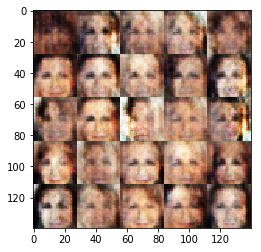

Epoch 1/3... Discriminator Loss: 0.8228... Generator Loss: 1.6144
Epoch 1/3... Discriminator Loss: 0.8440... Generator Loss: 1.1452
Epoch 1/3... Discriminator Loss: 0.8915... Generator Loss: 0.9875
Epoch 1/3... Discriminator Loss: 1.2626... Generator Loss: 0.6914
Epoch 1/3... Discriminator Loss: 1.6147... Generator Loss: 0.5491


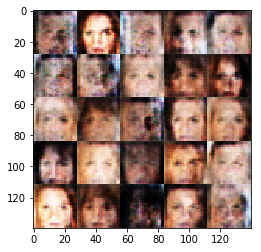

Epoch 1/3... Discriminator Loss: 1.3891... Generator Loss: 1.2110
Epoch 1/3... Discriminator Loss: 1.0475... Generator Loss: 0.7138
Epoch 1/3... Discriminator Loss: 0.7849... Generator Loss: 1.3725
Epoch 1/3... Discriminator Loss: 0.9806... Generator Loss: 1.4761
Epoch 1/3... Discriminator Loss: 0.7678... Generator Loss: 1.0588


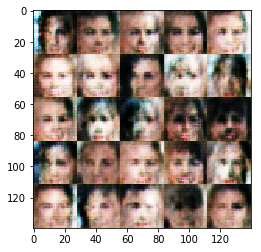

Epoch 1/3... Discriminator Loss: 0.7328... Generator Loss: 1.4576
Epoch 1/3... Discriminator Loss: 0.8428... Generator Loss: 1.5193
Epoch 1/3... Discriminator Loss: 1.0243... Generator Loss: 1.7471
Epoch 1/3... Discriminator Loss: 0.8905... Generator Loss: 2.0077
Epoch 1/3... Discriminator Loss: 0.8340... Generator Loss: 2.0288


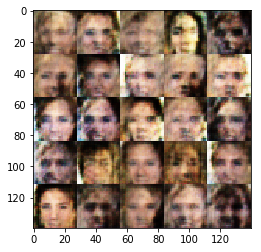

Epoch 1/3... Discriminator Loss: 1.0647... Generator Loss: 1.5222
Epoch 1/3... Discriminator Loss: 1.0593... Generator Loss: 2.2298
Epoch 1/3... Discriminator Loss: 1.1981... Generator Loss: 1.1665
Epoch 1/3... Discriminator Loss: 1.0387... Generator Loss: 1.0417
Epoch 1/3... Discriminator Loss: 0.8362... Generator Loss: 2.6289


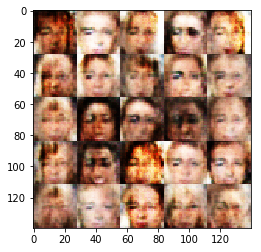

Epoch 1/3... Discriminator Loss: 1.2232... Generator Loss: 2.8519
Epoch 1/3... Discriminator Loss: 0.8932... Generator Loss: 1.9746
Epoch 1/3... Discriminator Loss: 1.0441... Generator Loss: 1.9958
Epoch 1/3... Discriminator Loss: 0.7944... Generator Loss: 1.6939
Epoch 1/3... Discriminator Loss: 0.8041... Generator Loss: 1.9889


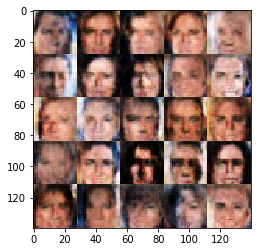

Epoch 1/3... Discriminator Loss: 0.9248... Generator Loss: 1.3829
Epoch 1/3... Discriminator Loss: 0.9617... Generator Loss: 2.6800
Epoch 1/3... Discriminator Loss: 1.0775... Generator Loss: 0.8523
Epoch 1/3... Discriminator Loss: 0.9444... Generator Loss: 1.2831
Epoch 1/3... Discriminator Loss: 0.8269... Generator Loss: 1.3407


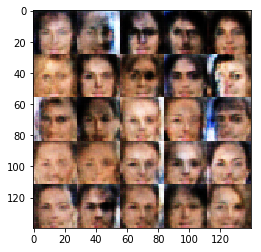

Epoch 1/3... Discriminator Loss: 0.9880... Generator Loss: 1.2903
Epoch 1/3... Discriminator Loss: 1.0433... Generator Loss: 1.7304
Epoch 1/3... Discriminator Loss: 0.9299... Generator Loss: 1.2590
Epoch 1/3... Discriminator Loss: 1.0367... Generator Loss: 0.8970
Epoch 1/3... Discriminator Loss: 0.9661... Generator Loss: 1.1227


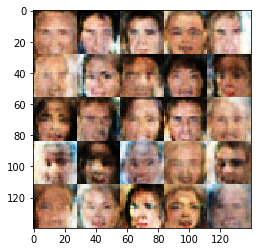

Epoch 1/3... Discriminator Loss: 1.0151... Generator Loss: 1.0503
Epoch 1/3... Discriminator Loss: 0.9602... Generator Loss: 1.7347
Epoch 1/3... Discriminator Loss: 1.0533... Generator Loss: 0.7100
Epoch 1/3... Discriminator Loss: 1.0417... Generator Loss: 1.3208
Epoch 1/3... Discriminator Loss: 1.1084... Generator Loss: 0.6311


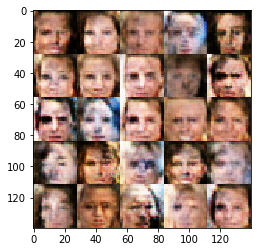

Epoch 1/3... Discriminator Loss: 0.9730... Generator Loss: 0.8385
Epoch 1/3... Discriminator Loss: 0.8940... Generator Loss: 1.2652
Epoch 1/3... Discriminator Loss: 0.8862... Generator Loss: 1.1050
Epoch 1/3... Discriminator Loss: 1.2908... Generator Loss: 0.7025
Epoch 1/3... Discriminator Loss: 0.6909... Generator Loss: 1.2399


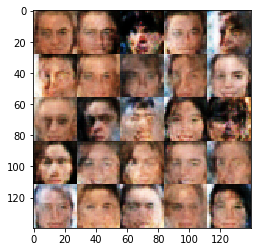

Epoch 1/3... Discriminator Loss: 1.0839... Generator Loss: 1.3627
Epoch 1/3... Discriminator Loss: 0.7703... Generator Loss: 0.9928
Epoch 1/3... Discriminator Loss: 0.8464... Generator Loss: 1.3479
Epoch 1/3... Discriminator Loss: 1.1618... Generator Loss: 1.1703
Epoch 1/3... Discriminator Loss: 1.2821... Generator Loss: 0.6810


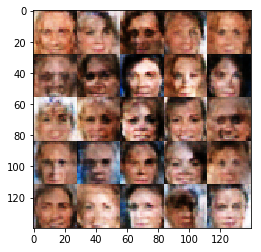

Epoch 1/3... Discriminator Loss: 1.3571... Generator Loss: 0.7529
Epoch 1/3... Discriminator Loss: 0.9652... Generator Loss: 1.1097
Epoch 1/3... Discriminator Loss: 1.6710... Generator Loss: 0.3462
Epoch 1/3... Discriminator Loss: 0.8401... Generator Loss: 1.3734
Epoch 1/3... Discriminator Loss: 1.3923... Generator Loss: 0.8734


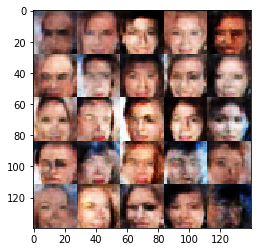

Epoch 1/3... Discriminator Loss: 0.9011... Generator Loss: 1.2088
Epoch 1/3... Discriminator Loss: 1.0984... Generator Loss: 1.0645
Epoch 1/3... Discriminator Loss: 0.8483... Generator Loss: 1.4708
Epoch 1/3... Discriminator Loss: 1.0011... Generator Loss: 0.9587
Epoch 1/3... Discriminator Loss: 0.8033... Generator Loss: 1.5097


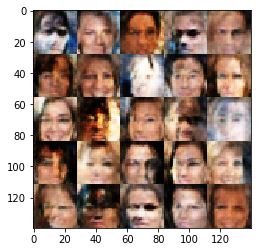

Epoch 1/3... Discriminator Loss: 0.8303... Generator Loss: 1.1637
Epoch 1/3... Discriminator Loss: 0.8169... Generator Loss: 1.4146
Epoch 1/3... Discriminator Loss: 0.9406... Generator Loss: 2.2088
Epoch 1/3... Discriminator Loss: 1.1041... Generator Loss: 1.4352
Epoch 1/3... Discriminator Loss: 1.1600... Generator Loss: 1.8892


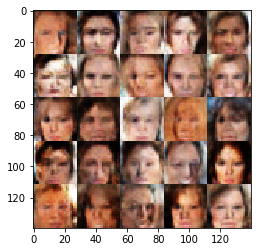

Epoch 1/3... Discriminator Loss: 1.0879... Generator Loss: 0.7911
Epoch 1/3... Discriminator Loss: 1.1979... Generator Loss: 0.5780
Epoch 1/3... Discriminator Loss: 0.9114... Generator Loss: 1.2701
Epoch 1/3... Discriminator Loss: 1.0135... Generator Loss: 1.1799
Epoch 1/3... Discriminator Loss: 1.0172... Generator Loss: 0.9740


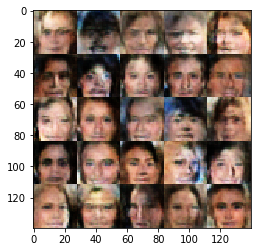

Epoch 1/3... Discriminator Loss: 0.9700... Generator Loss: 1.1253
Epoch 1/3... Discriminator Loss: 0.9974... Generator Loss: 1.0730
Epoch 1/3... Discriminator Loss: 0.8674... Generator Loss: 0.8897
Epoch 1/3... Discriminator Loss: 0.8721... Generator Loss: 1.2676
Epoch 1/3... Discriminator Loss: 0.9781... Generator Loss: 1.1745


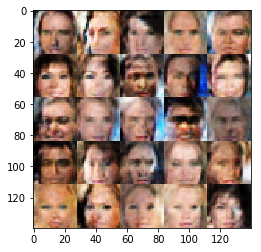

Epoch 1/3... Discriminator Loss: 0.7822... Generator Loss: 1.7540
Epoch 1/3... Discriminator Loss: 1.7429... Generator Loss: 0.2619
Epoch 1/3... Discriminator Loss: 1.0038... Generator Loss: 1.9349
Epoch 1/3... Discriminator Loss: 0.8963... Generator Loss: 1.1604
Epoch 1/3... Discriminator Loss: 0.9671... Generator Loss: 1.0902


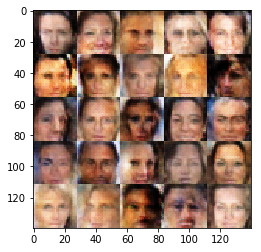

Epoch 1/3... Discriminator Loss: 0.8575... Generator Loss: 0.9901
Epoch 1/3... Discriminator Loss: 1.0441... Generator Loss: 0.9963
Epoch 1/3... Discriminator Loss: 1.0905... Generator Loss: 0.9401
Epoch 1/3... Discriminator Loss: 0.9166... Generator Loss: 1.1603
Epoch 1/3... Discriminator Loss: 1.0604... Generator Loss: 1.3667


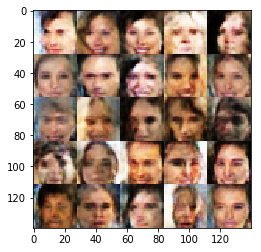

Epoch 1/3... Discriminator Loss: 0.8875... Generator Loss: 1.1997
Epoch 1/3... Discriminator Loss: 1.4353... Generator Loss: 0.5507
Epoch 1/3... Discriminator Loss: 0.9831... Generator Loss: 1.7714
Epoch 1/3... Discriminator Loss: 0.9193... Generator Loss: 0.9771
Epoch 1/3... Discriminator Loss: 1.0024... Generator Loss: 0.9931


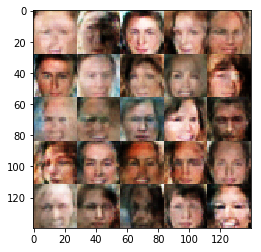

Epoch 1/3... Discriminator Loss: 0.9552... Generator Loss: 1.0955
Epoch 1/3... Discriminator Loss: 0.8703... Generator Loss: 1.5460
Epoch 1/3... Discriminator Loss: 0.9024... Generator Loss: 1.0022
Epoch 1/3... Discriminator Loss: 1.2798... Generator Loss: 2.0740
Epoch 1/3... Discriminator Loss: 0.7442... Generator Loss: 1.6311


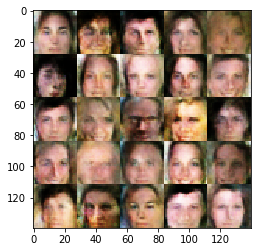

Epoch 1/3... Discriminator Loss: 0.6602... Generator Loss: 1.3826
Epoch 1/3... Discriminator Loss: 0.9979... Generator Loss: 0.9863
Epoch 1/3... Discriminator Loss: 0.8138... Generator Loss: 1.4633
Epoch 1/3... Discriminator Loss: 1.1519... Generator Loss: 1.4386
Epoch 1/3... Discriminator Loss: 0.9179... Generator Loss: 1.1728


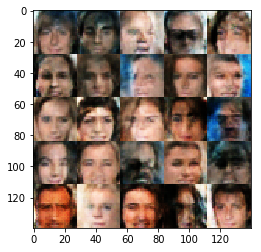

Epoch 1/3... Discriminator Loss: 0.8773... Generator Loss: 1.2131
Epoch 1/3... Discriminator Loss: 1.1467... Generator Loss: 0.7158
Epoch 1/3... Discriminator Loss: 1.0411... Generator Loss: 0.9646
Epoch 1/3... Discriminator Loss: 0.8741... Generator Loss: 1.5403
Epoch 1/3... Discriminator Loss: 0.9366... Generator Loss: 1.1644


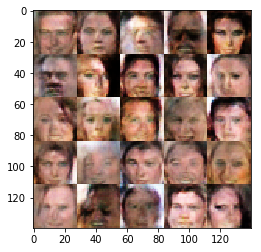

Epoch 1/3... Discriminator Loss: 0.7257... Generator Loss: 1.6925
Epoch 1/3... Discriminator Loss: 0.8848... Generator Loss: 1.2953
Epoch 1/3... Discriminator Loss: 0.8952... Generator Loss: 1.0028
Epoch 1/3... Discriminator Loss: 1.0352... Generator Loss: 1.9399
Epoch 1/3... Discriminator Loss: 0.8839... Generator Loss: 1.2874


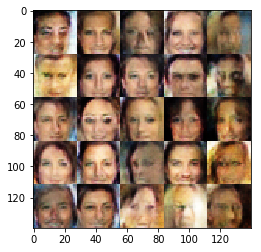

Epoch 1/3... Discriminator Loss: 0.9030... Generator Loss: 0.8908
Epoch 1/3... Discriminator Loss: 2.0305... Generator Loss: 0.2013
Epoch 1/3... Discriminator Loss: 1.0514... Generator Loss: 1.0023
Epoch 2/3... Discriminator Loss: 1.1134... Generator Loss: 1.3037
Epoch 2/3... Discriminator Loss: 0.9340... Generator Loss: 1.7557


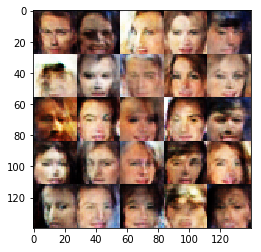

Epoch 2/3... Discriminator Loss: 1.0233... Generator Loss: 1.0510
Epoch 2/3... Discriminator Loss: 1.1383... Generator Loss: 0.9451
Epoch 2/3... Discriminator Loss: 1.2492... Generator Loss: 0.6756
Epoch 2/3... Discriminator Loss: 0.9227... Generator Loss: 1.5045
Epoch 2/3... Discriminator Loss: 1.1816... Generator Loss: 1.0283


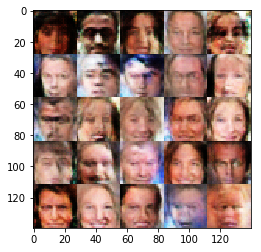

Epoch 2/3... Discriminator Loss: 0.8648... Generator Loss: 1.5570
Epoch 2/3... Discriminator Loss: 1.0482... Generator Loss: 0.8648
Epoch 2/3... Discriminator Loss: 1.1041... Generator Loss: 0.9880
Epoch 2/3... Discriminator Loss: 1.3304... Generator Loss: 0.4825
Epoch 2/3... Discriminator Loss: 0.8986... Generator Loss: 0.9497


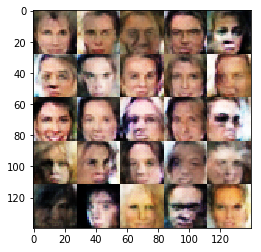

Epoch 2/3... Discriminator Loss: 1.0120... Generator Loss: 0.6623
Epoch 2/3... Discriminator Loss: 0.9897... Generator Loss: 2.1636
Epoch 2/3... Discriminator Loss: 1.0109... Generator Loss: 0.8943
Epoch 2/3... Discriminator Loss: 1.3955... Generator Loss: 0.6091
Epoch 2/3... Discriminator Loss: 1.0197... Generator Loss: 1.6562


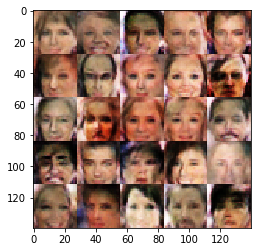

Epoch 2/3... Discriminator Loss: 1.1939... Generator Loss: 0.7246
Epoch 2/3... Discriminator Loss: 1.0569... Generator Loss: 0.9245
Epoch 2/3... Discriminator Loss: 1.1937... Generator Loss: 1.7941
Epoch 2/3... Discriminator Loss: 0.9911... Generator Loss: 0.7293
Epoch 2/3... Discriminator Loss: 1.3202... Generator Loss: 2.5249


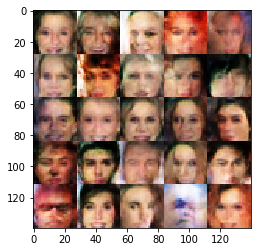

Epoch 2/3... Discriminator Loss: 0.9075... Generator Loss: 1.1164
Epoch 2/3... Discriminator Loss: 0.9212... Generator Loss: 1.0304
Epoch 2/3... Discriminator Loss: 0.9021... Generator Loss: 1.5619
Epoch 2/3... Discriminator Loss: 1.2621... Generator Loss: 1.7646
Epoch 2/3... Discriminator Loss: 1.1247... Generator Loss: 1.0037


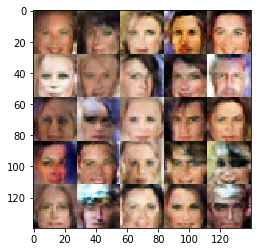

Epoch 2/3... Discriminator Loss: 0.8662... Generator Loss: 1.1509
Epoch 2/3... Discriminator Loss: 1.1703... Generator Loss: 1.0730
Epoch 2/3... Discriminator Loss: 1.3185... Generator Loss: 0.5821
Epoch 2/3... Discriminator Loss: 0.9542... Generator Loss: 1.2039
Epoch 2/3... Discriminator Loss: 0.9036... Generator Loss: 1.4934


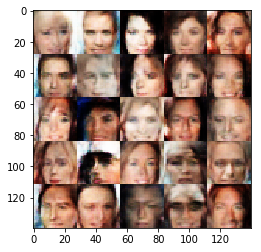

Epoch 2/3... Discriminator Loss: 0.8602... Generator Loss: 1.3532
Epoch 2/3... Discriminator Loss: 1.0405... Generator Loss: 0.8260
Epoch 2/3... Discriminator Loss: 0.8746... Generator Loss: 1.2444
Epoch 2/3... Discriminator Loss: 0.9869... Generator Loss: 1.4972
Epoch 2/3... Discriminator Loss: 1.2133... Generator Loss: 0.7338


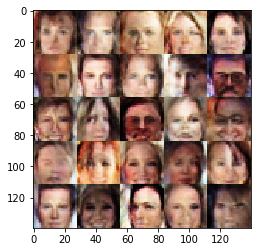

Epoch 2/3... Discriminator Loss: 1.1015... Generator Loss: 1.6562
Epoch 2/3... Discriminator Loss: 1.0891... Generator Loss: 0.9715
Epoch 2/3... Discriminator Loss: 0.8557... Generator Loss: 1.2049
Epoch 2/3... Discriminator Loss: 0.9372... Generator Loss: 1.4558
Epoch 2/3... Discriminator Loss: 1.0819... Generator Loss: 0.7046


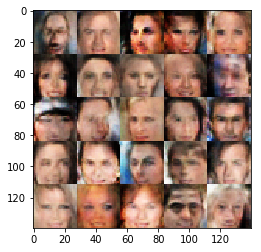

Epoch 2/3... Discriminator Loss: 0.9370... Generator Loss: 0.9661
Epoch 2/3... Discriminator Loss: 1.0053... Generator Loss: 1.2669
Epoch 2/3... Discriminator Loss: 0.9633... Generator Loss: 1.3180
Epoch 2/3... Discriminator Loss: 0.9954... Generator Loss: 1.0130
Epoch 2/3... Discriminator Loss: 1.4811... Generator Loss: 0.4738


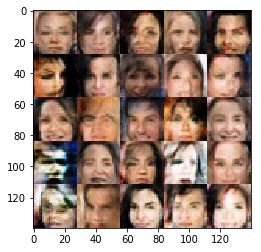

Epoch 2/3... Discriminator Loss: 0.8645... Generator Loss: 1.4816
Epoch 2/3... Discriminator Loss: 1.2309... Generator Loss: 0.6758
Epoch 2/3... Discriminator Loss: 0.8228... Generator Loss: 1.2484
Epoch 2/3... Discriminator Loss: 0.9868... Generator Loss: 1.4655
Epoch 2/3... Discriminator Loss: 0.9831... Generator Loss: 1.8049


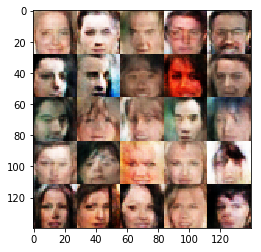

Epoch 2/3... Discriminator Loss: 1.1846... Generator Loss: 1.0222
Epoch 2/3... Discriminator Loss: 1.6650... Generator Loss: 0.4404
Epoch 2/3... Discriminator Loss: 1.0868... Generator Loss: 1.0222
Epoch 2/3... Discriminator Loss: 0.8528... Generator Loss: 1.2747
Epoch 2/3... Discriminator Loss: 1.1551... Generator Loss: 1.2911


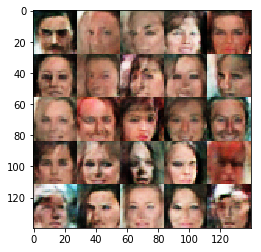

Epoch 2/3... Discriminator Loss: 0.8980... Generator Loss: 1.0467
Epoch 2/3... Discriminator Loss: 1.1775... Generator Loss: 1.6074
Epoch 2/3... Discriminator Loss: 1.0058... Generator Loss: 1.1860
Epoch 2/3... Discriminator Loss: 1.3230... Generator Loss: 0.6425
Epoch 2/3... Discriminator Loss: 0.8896... Generator Loss: 1.4843


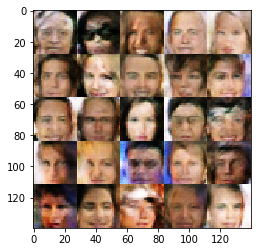

Epoch 2/3... Discriminator Loss: 0.9804... Generator Loss: 1.1115
Epoch 2/3... Discriminator Loss: 0.9469... Generator Loss: 1.8258
Epoch 2/3... Discriminator Loss: 0.9007... Generator Loss: 1.6909
Epoch 2/3... Discriminator Loss: 1.0659... Generator Loss: 0.9965
Epoch 2/3... Discriminator Loss: 1.2434... Generator Loss: 0.6026


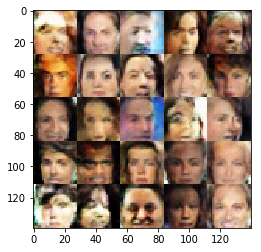

Epoch 2/3... Discriminator Loss: 1.2408... Generator Loss: 0.9346
Epoch 2/3... Discriminator Loss: 1.3045... Generator Loss: 0.5101
Epoch 2/3... Discriminator Loss: 1.5309... Generator Loss: 0.5460
Epoch 2/3... Discriminator Loss: 1.9375... Generator Loss: 0.3666
Epoch 2/3... Discriminator Loss: 1.1714... Generator Loss: 2.0271


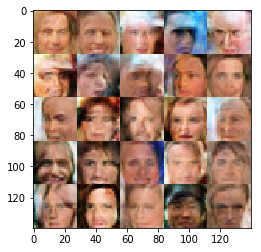

Epoch 2/3... Discriminator Loss: 1.0720... Generator Loss: 0.8901
Epoch 2/3... Discriminator Loss: 0.9987... Generator Loss: 0.9707
Epoch 2/3... Discriminator Loss: 1.1557... Generator Loss: 0.7599
Epoch 2/3... Discriminator Loss: 1.1685... Generator Loss: 0.6377
Epoch 2/3... Discriminator Loss: 1.3295... Generator Loss: 0.7307


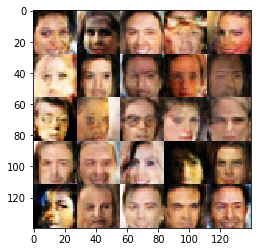

Epoch 2/3... Discriminator Loss: 0.8895... Generator Loss: 1.0404
Epoch 2/3... Discriminator Loss: 1.0537... Generator Loss: 1.7034
Epoch 2/3... Discriminator Loss: 1.2354... Generator Loss: 0.8578
Epoch 2/3... Discriminator Loss: 0.8327... Generator Loss: 1.2702
Epoch 2/3... Discriminator Loss: 1.0241... Generator Loss: 1.3639


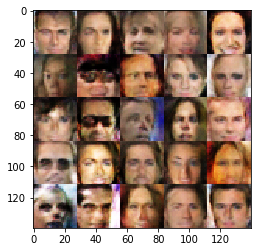

Epoch 2/3... Discriminator Loss: 1.3258... Generator Loss: 0.5473
Epoch 2/3... Discriminator Loss: 0.6832... Generator Loss: 1.5355
Epoch 2/3... Discriminator Loss: 0.7212... Generator Loss: 1.8829
Epoch 2/3... Discriminator Loss: 0.9583... Generator Loss: 1.3837
Epoch 2/3... Discriminator Loss: 0.9961... Generator Loss: 0.9242


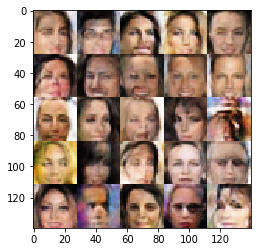

Epoch 2/3... Discriminator Loss: 0.7006... Generator Loss: 1.4409
Epoch 2/3... Discriminator Loss: 0.8951... Generator Loss: 0.9327
Epoch 2/3... Discriminator Loss: 1.0442... Generator Loss: 1.4437
Epoch 2/3... Discriminator Loss: 0.8350... Generator Loss: 1.5623
Epoch 2/3... Discriminator Loss: 1.0164... Generator Loss: 1.7484


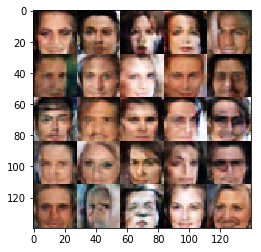

Epoch 2/3... Discriminator Loss: 1.0037... Generator Loss: 1.5298
Epoch 2/3... Discriminator Loss: 0.8730... Generator Loss: 0.9909
Epoch 2/3... Discriminator Loss: 1.2941... Generator Loss: 0.6362
Epoch 2/3... Discriminator Loss: 0.8340... Generator Loss: 1.6797
Epoch 2/3... Discriminator Loss: 1.3799... Generator Loss: 0.5974


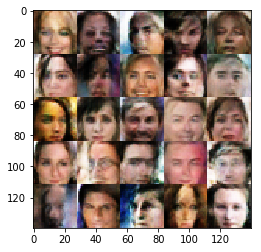

Epoch 2/3... Discriminator Loss: 1.2411... Generator Loss: 0.7403
Epoch 2/3... Discriminator Loss: 1.1182... Generator Loss: 0.7518
Epoch 2/3... Discriminator Loss: 0.9256... Generator Loss: 1.5827
Epoch 2/3... Discriminator Loss: 0.7736... Generator Loss: 1.6459
Epoch 2/3... Discriminator Loss: 1.1844... Generator Loss: 1.5054


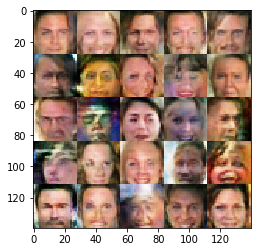

Epoch 2/3... Discriminator Loss: 0.9271... Generator Loss: 1.5837
Epoch 2/3... Discriminator Loss: 1.0434... Generator Loss: 1.8550
Epoch 2/3... Discriminator Loss: 0.9135... Generator Loss: 0.9854
Epoch 2/3... Discriminator Loss: 1.0326... Generator Loss: 0.9171
Epoch 2/3... Discriminator Loss: 0.8341... Generator Loss: 1.2243


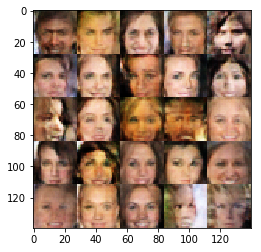

Epoch 2/3... Discriminator Loss: 1.0683... Generator Loss: 1.5564
Epoch 2/3... Discriminator Loss: 1.2157... Generator Loss: 2.1395
Epoch 2/3... Discriminator Loss: 0.8937... Generator Loss: 1.0824
Epoch 2/3... Discriminator Loss: 1.0110... Generator Loss: 0.7755
Epoch 2/3... Discriminator Loss: 1.2360... Generator Loss: 0.6503


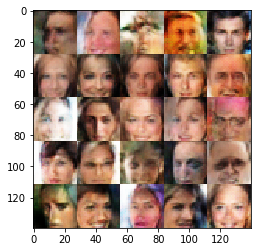

Epoch 2/3... Discriminator Loss: 0.7915... Generator Loss: 1.3332
Epoch 2/3... Discriminator Loss: 0.9667... Generator Loss: 1.3737
Epoch 2/3... Discriminator Loss: 0.9232... Generator Loss: 1.1982
Epoch 2/3... Discriminator Loss: 0.9431... Generator Loss: 1.5648
Epoch 2/3... Discriminator Loss: 1.0770... Generator Loss: 0.7640


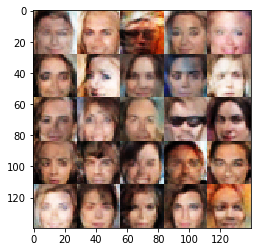

Epoch 2/3... Discriminator Loss: 0.9823... Generator Loss: 0.7749
Epoch 2/3... Discriminator Loss: 0.8156... Generator Loss: 1.3141
Epoch 2/3... Discriminator Loss: 0.8840... Generator Loss: 1.2640
Epoch 2/3... Discriminator Loss: 1.1173... Generator Loss: 1.1497
Epoch 2/3... Discriminator Loss: 1.1554... Generator Loss: 1.9369


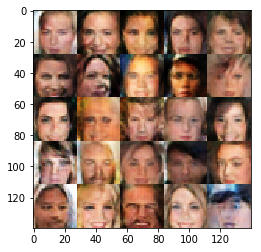

Epoch 2/3... Discriminator Loss: 0.9013... Generator Loss: 1.0476
Epoch 2/3... Discriminator Loss: 0.9150... Generator Loss: 0.9158
Epoch 2/3... Discriminator Loss: 0.8016... Generator Loss: 1.1347
Epoch 2/3... Discriminator Loss: 1.0175... Generator Loss: 1.3124
Epoch 2/3... Discriminator Loss: 1.0955... Generator Loss: 0.7110


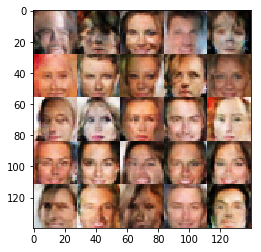

Epoch 2/3... Discriminator Loss: 0.8841... Generator Loss: 0.8793
Epoch 2/3... Discriminator Loss: 0.8173... Generator Loss: 0.9131
Epoch 2/3... Discriminator Loss: 1.6068... Generator Loss: 0.5644
Epoch 2/3... Discriminator Loss: 0.9935... Generator Loss: 1.5456
Epoch 2/3... Discriminator Loss: 0.8980... Generator Loss: 1.1630


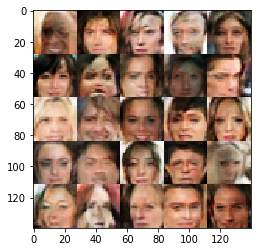

Epoch 2/3... Discriminator Loss: 0.7637... Generator Loss: 1.5026
Epoch 2/3... Discriminator Loss: 1.0490... Generator Loss: 1.0105
Epoch 2/3... Discriminator Loss: 0.8878... Generator Loss: 1.2839
Epoch 2/3... Discriminator Loss: 0.9439... Generator Loss: 0.9855
Epoch 2/3... Discriminator Loss: 0.8438... Generator Loss: 0.9894


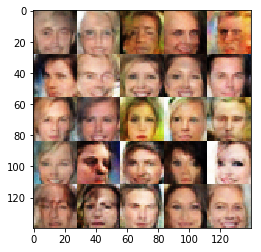

Epoch 2/3... Discriminator Loss: 0.8292... Generator Loss: 1.1668
Epoch 2/3... Discriminator Loss: 0.6971... Generator Loss: 1.8684
Epoch 2/3... Discriminator Loss: 1.0596... Generator Loss: 1.1553
Epoch 2/3... Discriminator Loss: 0.7158... Generator Loss: 1.7842
Epoch 2/3... Discriminator Loss: 1.1519... Generator Loss: 1.1623


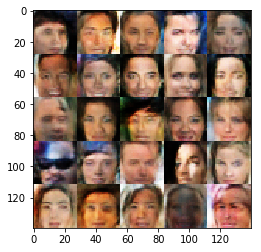

Epoch 2/3... Discriminator Loss: 1.2063... Generator Loss: 1.2853
Epoch 2/3... Discriminator Loss: 1.0237... Generator Loss: 1.0624
Epoch 2/3... Discriminator Loss: 1.1856... Generator Loss: 1.0774
Epoch 2/3... Discriminator Loss: 0.8518... Generator Loss: 0.9917
Epoch 2/3... Discriminator Loss: 0.9678... Generator Loss: 2.1656


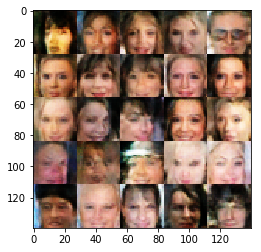

Epoch 2/3... Discriminator Loss: 1.0511... Generator Loss: 2.2591
Epoch 2/3... Discriminator Loss: 0.8324... Generator Loss: 1.0121
Epoch 2/3... Discriminator Loss: 0.8201... Generator Loss: 2.5535
Epoch 2/3... Discriminator Loss: 0.9518... Generator Loss: 1.1944
Epoch 2/3... Discriminator Loss: 1.4135... Generator Loss: 0.5879


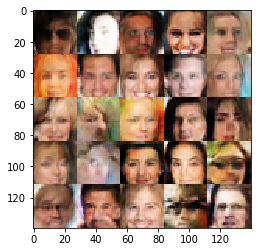

Epoch 2/3... Discriminator Loss: 1.0034... Generator Loss: 0.7328
Epoch 2/3... Discriminator Loss: 0.7084... Generator Loss: 1.6231
Epoch 2/3... Discriminator Loss: 1.0806... Generator Loss: 0.5694
Epoch 2/3... Discriminator Loss: 0.8188... Generator Loss: 1.1815
Epoch 2/3... Discriminator Loss: 0.7568... Generator Loss: 1.0126


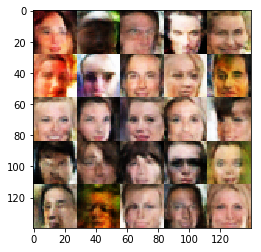

Epoch 2/3... Discriminator Loss: 1.0855... Generator Loss: 2.8155
Epoch 3/3... Discriminator Loss: 0.8768... Generator Loss: 1.0177
Epoch 3/3... Discriminator Loss: 1.0020... Generator Loss: 0.9459
Epoch 3/3... Discriminator Loss: 1.0905... Generator Loss: 0.6938
Epoch 3/3... Discriminator Loss: 0.9828... Generator Loss: 1.9072


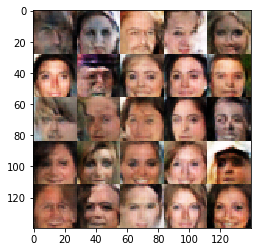

Epoch 3/3... Discriminator Loss: 0.9211... Generator Loss: 1.0980
Epoch 3/3... Discriminator Loss: 0.9676... Generator Loss: 2.0447
Epoch 3/3... Discriminator Loss: 0.5428... Generator Loss: 1.4386
Epoch 3/3... Discriminator Loss: 1.1604... Generator Loss: 0.9227
Epoch 3/3... Discriminator Loss: 1.0104... Generator Loss: 1.5114


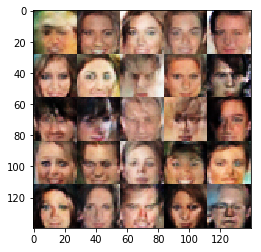

Epoch 3/3... Discriminator Loss: 1.4624... Generator Loss: 2.1923
Epoch 3/3... Discriminator Loss: 1.0049... Generator Loss: 1.2085
Epoch 3/3... Discriminator Loss: 0.6261... Generator Loss: 1.3516
Epoch 3/3... Discriminator Loss: 0.9119... Generator Loss: 1.9685
Epoch 3/3... Discriminator Loss: 1.2730... Generator Loss: 2.1447


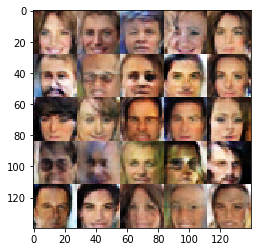

Epoch 3/3... Discriminator Loss: 0.9094... Generator Loss: 1.4369
Epoch 3/3... Discriminator Loss: 0.9665... Generator Loss: 1.6055
Epoch 3/3... Discriminator Loss: 0.9286... Generator Loss: 1.4027
Epoch 3/3... Discriminator Loss: 0.8717... Generator Loss: 1.2289
Epoch 3/3... Discriminator Loss: 0.7925... Generator Loss: 1.8137


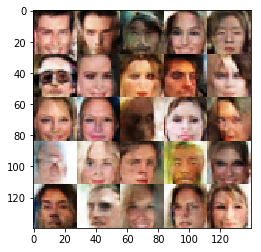

Epoch 3/3... Discriminator Loss: 0.8322... Generator Loss: 1.4723
Epoch 3/3... Discriminator Loss: 0.9687... Generator Loss: 1.0556
Epoch 3/3... Discriminator Loss: 0.8881... Generator Loss: 1.1377
Epoch 3/3... Discriminator Loss: 1.1796... Generator Loss: 0.8365
Epoch 3/3... Discriminator Loss: 1.4620... Generator Loss: 0.4165


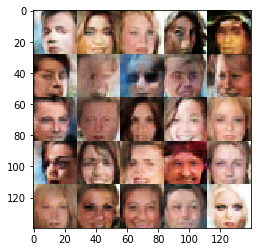

Epoch 3/3... Discriminator Loss: 1.0026... Generator Loss: 0.9315
Epoch 3/3... Discriminator Loss: 0.8362... Generator Loss: 1.2873
Epoch 3/3... Discriminator Loss: 0.9088... Generator Loss: 1.8642
Epoch 3/3... Discriminator Loss: 0.8266... Generator Loss: 0.9099
Epoch 3/3... Discriminator Loss: 0.7898... Generator Loss: 1.4829


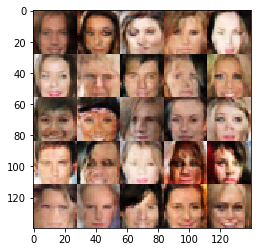

Epoch 3/3... Discriminator Loss: 1.0293... Generator Loss: 0.6521
Epoch 3/3... Discriminator Loss: 1.0000... Generator Loss: 1.0313
Epoch 3/3... Discriminator Loss: 0.8559... Generator Loss: 1.8114
Epoch 3/3... Discriminator Loss: 1.0410... Generator Loss: 1.1604
Epoch 3/3... Discriminator Loss: 0.9560... Generator Loss: 1.3460


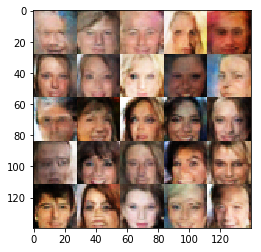

Epoch 3/3... Discriminator Loss: 0.9908... Generator Loss: 1.4957
Epoch 3/3... Discriminator Loss: 0.8088... Generator Loss: 1.1407
Epoch 3/3... Discriminator Loss: 0.6859... Generator Loss: 1.2329
Epoch 3/3... Discriminator Loss: 1.1915... Generator Loss: 0.7593
Epoch 3/3... Discriminator Loss: 1.1185... Generator Loss: 0.4063


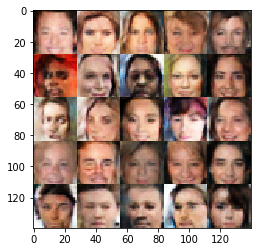

Epoch 3/3... Discriminator Loss: 0.8780... Generator Loss: 1.1245
Epoch 3/3... Discriminator Loss: 0.5742... Generator Loss: 1.9958
Epoch 3/3... Discriminator Loss: 0.8434... Generator Loss: 1.6389
Epoch 3/3... Discriminator Loss: 1.1044... Generator Loss: 0.7666
Epoch 3/3... Discriminator Loss: 0.9361... Generator Loss: 1.5737


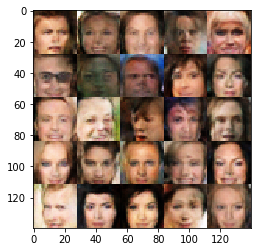

Epoch 3/3... Discriminator Loss: 0.7411... Generator Loss: 1.7786
Epoch 3/3... Discriminator Loss: 0.9706... Generator Loss: 1.1358
Epoch 3/3... Discriminator Loss: 0.8359... Generator Loss: 1.6917
Epoch 3/3... Discriminator Loss: 0.8309... Generator Loss: 0.9734
Epoch 3/3... Discriminator Loss: 1.1310... Generator Loss: 0.6414


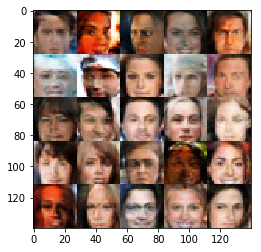

Epoch 3/3... Discriminator Loss: 0.8168... Generator Loss: 1.2036
Epoch 3/3... Discriminator Loss: 1.2047... Generator Loss: 0.7921
Epoch 3/3... Discriminator Loss: 1.0961... Generator Loss: 1.0504
Epoch 3/3... Discriminator Loss: 0.8819... Generator Loss: 0.9415
Epoch 3/3... Discriminator Loss: 0.8526... Generator Loss: 1.0172


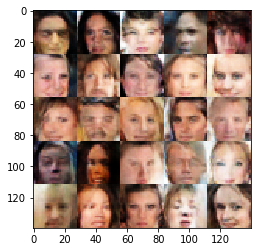

Epoch 3/3... Discriminator Loss: 0.7996... Generator Loss: 1.3648
Epoch 3/3... Discriminator Loss: 0.7256... Generator Loss: 1.9232
Epoch 3/3... Discriminator Loss: 0.9712... Generator Loss: 0.7199
Epoch 3/3... Discriminator Loss: 0.8548... Generator Loss: 1.4013
Epoch 3/3... Discriminator Loss: 1.0045... Generator Loss: 1.3664


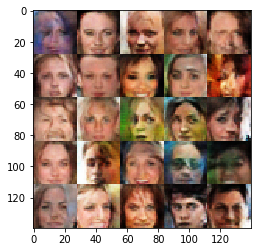

Epoch 3/3... Discriminator Loss: 1.0216... Generator Loss: 1.2715
Epoch 3/3... Discriminator Loss: 0.8205... Generator Loss: 1.2501
Epoch 3/3... Discriminator Loss: 0.8718... Generator Loss: 1.3680
Epoch 3/3... Discriminator Loss: 0.8370... Generator Loss: 1.0622
Epoch 3/3... Discriminator Loss: 0.8902... Generator Loss: 1.0083


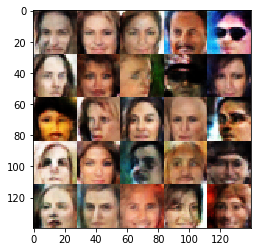

Epoch 3/3... Discriminator Loss: 0.9278... Generator Loss: 2.7820
Epoch 3/3... Discriminator Loss: 0.8557... Generator Loss: 1.1263
Epoch 3/3... Discriminator Loss: 0.6046... Generator Loss: 1.5774
Epoch 3/3... Discriminator Loss: 0.7809... Generator Loss: 1.5392
Epoch 3/3... Discriminator Loss: 0.8494... Generator Loss: 1.2778


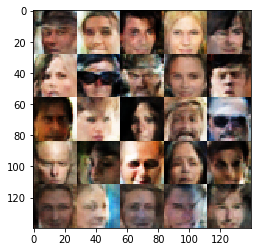

Epoch 3/3... Discriminator Loss: 0.7212... Generator Loss: 1.7440
Epoch 3/3... Discriminator Loss: 0.7907... Generator Loss: 1.2166
Epoch 3/3... Discriminator Loss: 0.7286... Generator Loss: 1.7947
Epoch 3/3... Discriminator Loss: 0.9594... Generator Loss: 1.2956
Epoch 3/3... Discriminator Loss: 0.8020... Generator Loss: 1.7437


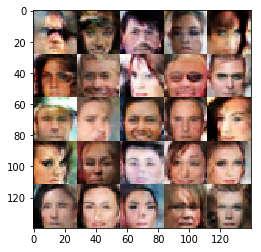

Epoch 3/3... Discriminator Loss: 0.9780... Generator Loss: 1.3929
Epoch 3/3... Discriminator Loss: 0.7950... Generator Loss: 0.9120
Epoch 3/3... Discriminator Loss: 0.8780... Generator Loss: 1.0983
Epoch 3/3... Discriminator Loss: 0.8002... Generator Loss: 1.3425
Epoch 3/3... Discriminator Loss: 1.0429... Generator Loss: 0.5798


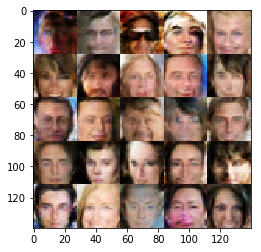

Epoch 3/3... Discriminator Loss: 1.0069... Generator Loss: 0.8636
Epoch 3/3... Discriminator Loss: 1.0744... Generator Loss: 1.3802
Epoch 3/3... Discriminator Loss: 0.9483... Generator Loss: 1.2673
Epoch 3/3... Discriminator Loss: 0.9960... Generator Loss: 1.1704
Epoch 3/3... Discriminator Loss: 0.7497... Generator Loss: 1.6248


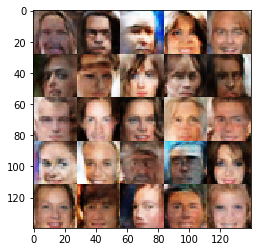

Epoch 3/3... Discriminator Loss: 1.2442... Generator Loss: 1.3078
Epoch 3/3... Discriminator Loss: 1.0966... Generator Loss: 2.8723
Epoch 3/3... Discriminator Loss: 1.1271... Generator Loss: 0.7140
Epoch 3/3... Discriminator Loss: 0.8584... Generator Loss: 1.8598
Epoch 3/3... Discriminator Loss: 0.8782... Generator Loss: 1.7071


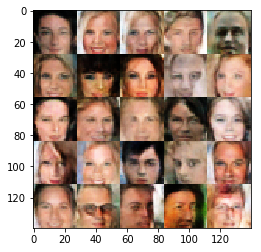

Epoch 3/3... Discriminator Loss: 0.8034... Generator Loss: 1.2984
Epoch 3/3... Discriminator Loss: 1.1379... Generator Loss: 0.7323
Epoch 3/3... Discriminator Loss: 1.5826... Generator Loss: 0.6473
Epoch 3/3... Discriminator Loss: 0.5652... Generator Loss: 1.3728
Epoch 3/3... Discriminator Loss: 0.7135... Generator Loss: 1.2817


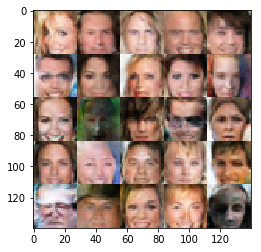

Epoch 3/3... Discriminator Loss: 0.8452... Generator Loss: 1.4401
Epoch 3/3... Discriminator Loss: 1.0049... Generator Loss: 1.4236
Epoch 3/3... Discriminator Loss: 0.7886... Generator Loss: 1.3662
Epoch 3/3... Discriminator Loss: 1.2694... Generator Loss: 0.7973
Epoch 3/3... Discriminator Loss: 0.6126... Generator Loss: 1.6124


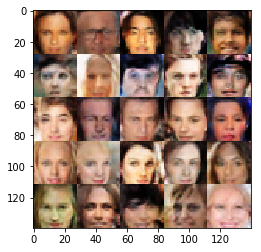

Epoch 3/3... Discriminator Loss: 0.5831... Generator Loss: 1.8818
Epoch 3/3... Discriminator Loss: 0.8498... Generator Loss: 0.9948
Epoch 3/3... Discriminator Loss: 0.6662... Generator Loss: 1.2892
Epoch 3/3... Discriminator Loss: 0.8245... Generator Loss: 1.1525
Epoch 3/3... Discriminator Loss: 0.7601... Generator Loss: 1.5644


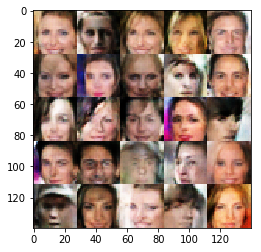

Epoch 3/3... Discriminator Loss: 0.7712... Generator Loss: 1.2095
Epoch 3/3... Discriminator Loss: 0.8198... Generator Loss: 0.9456
Epoch 3/3... Discriminator Loss: 0.9284... Generator Loss: 1.0869
Epoch 3/3... Discriminator Loss: 0.7951... Generator Loss: 1.7587
Epoch 3/3... Discriminator Loss: 0.8226... Generator Loss: 1.5051


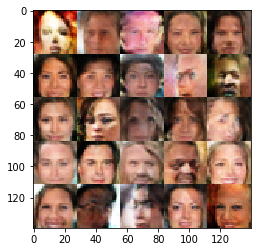

Epoch 3/3... Discriminator Loss: 0.9357... Generator Loss: 0.9861
Epoch 3/3... Discriminator Loss: 0.9487... Generator Loss: 2.3910
Epoch 3/3... Discriminator Loss: 1.1838... Generator Loss: 1.0651
Epoch 3/3... Discriminator Loss: 0.8058... Generator Loss: 1.3154
Epoch 3/3... Discriminator Loss: 0.7794... Generator Loss: 1.2752


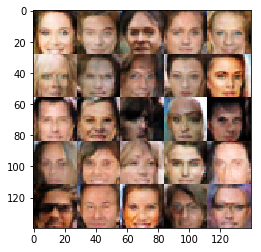

Epoch 3/3... Discriminator Loss: 0.6043... Generator Loss: 2.5761
Epoch 3/3... Discriminator Loss: 0.8421... Generator Loss: 1.0030
Epoch 3/3... Discriminator Loss: 0.7729... Generator Loss: 1.8231
Epoch 3/3... Discriminator Loss: 0.7838... Generator Loss: 1.4107
Epoch 3/3... Discriminator Loss: 0.7304... Generator Loss: 1.5730


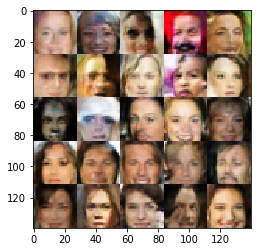

Epoch 3/3... Discriminator Loss: 0.9312... Generator Loss: 0.8832
Epoch 3/3... Discriminator Loss: 1.2487... Generator Loss: 0.5553
Epoch 3/3... Discriminator Loss: 0.5861... Generator Loss: 2.1269
Epoch 3/3... Discriminator Loss: 0.7783... Generator Loss: 1.8801
Epoch 3/3... Discriminator Loss: 0.6115... Generator Loss: 1.4008


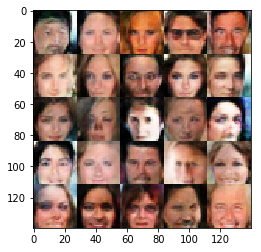

Epoch 3/3... Discriminator Loss: 0.8022... Generator Loss: 1.3133
Epoch 3/3... Discriminator Loss: 0.9017... Generator Loss: 0.9359
Epoch 3/3... Discriminator Loss: 0.7756... Generator Loss: 1.3689
Epoch 3/3... Discriminator Loss: 0.6519... Generator Loss: 1.5906
Epoch 3/3... Discriminator Loss: 0.5424... Generator Loss: 1.8479


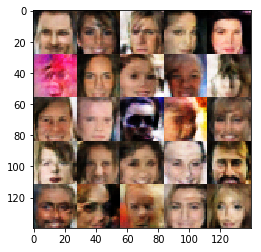

Epoch 3/3... Discriminator Loss: 0.7611... Generator Loss: 0.9444
Epoch 3/3... Discriminator Loss: 1.3739... Generator Loss: 0.6750
Epoch 3/3... Discriminator Loss: 0.7934... Generator Loss: 2.4680
Epoch 3/3... Discriminator Loss: 0.8357... Generator Loss: 1.0594
Epoch 3/3... Discriminator Loss: 0.8107... Generator Loss: 1.4976


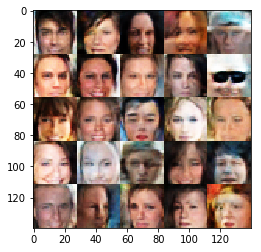

Epoch 3/3... Discriminator Loss: 0.7527... Generator Loss: 1.8057
Epoch 3/3... Discriminator Loss: 0.7265... Generator Loss: 1.5854
Epoch 3/3... Discriminator Loss: 0.6238... Generator Loss: 1.4254
Epoch 3/3... Discriminator Loss: 0.9400... Generator Loss: 1.5687
Epoch 3/3... Discriminator Loss: 0.9626... Generator Loss: 2.4210


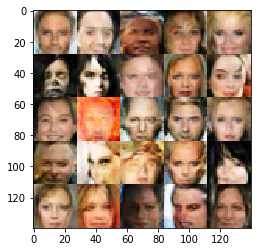

Epoch 3/3... Discriminator Loss: 0.6862... Generator Loss: 1.1374
Epoch 3/3... Discriminator Loss: 0.7658... Generator Loss: 1.0511
Epoch 3/3... Discriminator Loss: 0.5443... Generator Loss: 1.7514
Epoch 3/3... Discriminator Loss: 0.9522... Generator Loss: 1.1932
Epoch 3/3... Discriminator Loss: 0.8073... Generator Loss: 0.9620


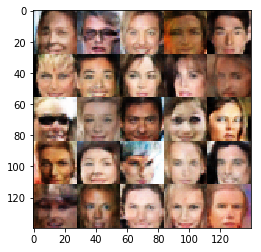

Epoch 3/3... Discriminator Loss: 0.7131... Generator Loss: 1.6557
Epoch 3/3... Discriminator Loss: 1.1464... Generator Loss: 3.2061
Epoch 3/3... Discriminator Loss: 0.7624... Generator Loss: 1.1420
Epoch 3/3... Discriminator Loss: 0.8146... Generator Loss: 1.4631
Epoch 3/3... Discriminator Loss: 1.2952... Generator Loss: 0.4937


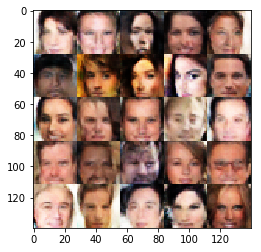

Epoch 3/3... Discriminator Loss: 0.7473... Generator Loss: 2.8942
Epoch 3/3... Discriminator Loss: 0.9719... Generator Loss: 1.0409
Epoch 3/3... Discriminator Loss: 0.7273... Generator Loss: 1.0905
Epoch 3/3... Discriminator Loss: 0.7971... Generator Loss: 1.7646
Epoch 3/3... Discriminator Loss: 0.8600... Generator Loss: 1.0337


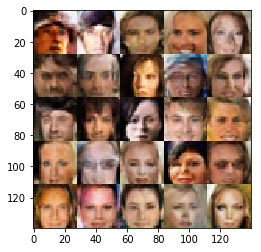

Epoch 3/3... Discriminator Loss: 0.9432... Generator Loss: 1.4593
Epoch 3/3... Discriminator Loss: 0.6293... Generator Loss: 2.3346
Epoch 3/3... Discriminator Loss: 0.8803... Generator Loss: 1.8886
Epoch 3/3... Discriminator Loss: 0.8291... Generator Loss: 0.8713


In [132]:
batch_size = 64
z_dim = 200
learning_rate = .0007
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.